# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    O_MODEL = tf.keras.applications.xception.Xception(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['block14_sepconv1', 'block14_sepconv2']
    LAST_LAYER = 'block14_sepconv2'
    PREPROCESSING = tf.keras.applications.xception.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.dense(o_outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.7893 - accuracy: 0.7394

947/947 [==============================] - 2518s 3s/step - loss: 0.7893 - accuracy: 0.7394 - val_loss: 0.8349 - val_accuracy: 0.7612
Epoch 2/200
947/947 [==============================] - ETA: 0s - loss: 0.6695 - accuracy: 0.7702

947/947 [==============================] - 2453s 3s/step - loss: 0.6695 - accuracy: 0.7702 - val_loss: 0.6686 - val_accuracy: 0.7789
Epoch 3/200
947/947 [==============================] - 2408s 3s/step - loss: 0.6125 - accuracy: 0.7843 - val_loss: 0.7256 - val_accuracy: 0.7624
Epoch 4/200
947/947 [==============================] - ETA: 0s - loss: 0.5803 - accuracy: 0.7952

947/947 [==============================] - 2465s 3s/step - loss: 0.5803 - accuracy: 0.7952 - val_loss: 0.6049 - val_accuracy: 0.7921
Epoch 5/200
947/947 [==============================] - 2571s 3s/step - loss: 0.5498 - accuracy: 0.8065 - val_loss: 0.6140 - val_accuracy: 0.7891
Epoch 6/200
947/947 [==============================] - ETA: 0s - loss: 0.5284 - accuracy: 0.8108

947/947 [==============================] - 2563s 3s/step - loss: 0.5284 - accuracy: 0.8108 - val_loss: 0.5215 - val_accuracy: 0.8198
Epoch 7/200
947/947 [==============================] - 2441s 3s/step - loss: 0.5067 - accuracy: 0.8201 - val_loss: 0.8127 - val_accuracy: 0.7830
Epoch 8/200
947/947 [==============================] - 2470s 3s/step - loss: 0.4904 - accuracy: 0.8250 - val_loss: 0.5240 - val_accuracy: 0.8146
Epoch 9/200
947/947 [==============================] - 2735s 3s/step - loss: 0.4663 - accuracy: 0.8340 - val_loss: 0.6811 - val_accuracy: 0.7962
Epoch 10/200
947/947 [==============================] - ETA: 0s - loss: 0.4527 - accuracy: 0.8370

947/947 [==============================] - 2913s 3s/step - loss: 0.4527 - accuracy: 0.8370 - val_loss: 0.4780 - val_accuracy: 0.8321
Epoch 11/200
947/947 [==============================] - 2875s 3s/step - loss: 0.4331 - accuracy: 0.8431 - val_loss: 0.5254 - val_accuracy: 0.8271
Epoch 12/200
947/947 [==============================] - 2889s 3s/step - loss: 0.4174 - accuracy: 0.8491 - val_loss: 0.5587 - val_accuracy: 0.8131
Epoch 13/200
947/947 [==============================] - 2866s 3s/step - loss: 0.4015 - accuracy: 0.8547 - val_loss: 0.4921 - val_accuracy: 0.8337
Epoch 14/200
947/947 [==============================] - 2880s 3s/step - loss: 0.3830 - accuracy: 0.8613 - val_loss: 0.5308 - val_accuracy: 0.8280
Epoch 15/200
947/947 [==============================] - 2861s 3s/step - loss: 0.3720 - accuracy: 0.8653 - val_loss: 0.5466 - val_accuracy: 0.8188
Epoch 16/200
947/947 [==============================] - 2502s 3s/step - loss: 0.3583 - accuracy: 0.8707 - val_loss: 0.5057 - val_accuracy

947/947 [==============================] - 2417s 3s/step - loss: 0.2810 - accuracy: 0.8972 - val_loss: 0.4212 - val_accuracy: 0.8626
Epoch 23/200
947/947 [==============================] - 2400s 3s/step - loss: 0.2690 - accuracy: 0.9015 - val_loss: 0.5221 - val_accuracy: 0.8367
Epoch 24/200
947/947 [==============================] - 2389s 3s/step - loss: 0.2517 - accuracy: 0.9090 - val_loss: 0.5398 - val_accuracy: 0.8373
Epoch 25/200
947/947 [==============================] - 2385s 3s/step - loss: 0.2457 - accuracy: 0.9098 - val_loss: 0.5564 - val_accuracy: 0.8423
Epoch 26/200
947/947 [==============================] - 2403s 3s/step - loss: 0.2304 - accuracy: 0.9179 - val_loss: 0.4615 - val_accuracy: 0.8510
Epoch 27/200
947/947 [==============================] - 2388s 3s/step - loss: 0.2239 - accuracy: 0.9178 - val_loss: 0.4966 - val_accuracy: 0.8496
Epoch 28/200
947/947 [==============================] - 2397s 3s/step - loss: 0.2185 - accuracy: 0.9193 - val_loss: 0.5012 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 257s 2s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9768606029538974,
 'basal cell carcinoma': 0.9868074329270078,
 'dermatofibroma': 0.983953710331663,
 'melanoma': 0.9477544138272419,
 'nevus': 0.972008719188413,
 'pigmented benign keratosis': 0.9864304447085904,
 'seborrheic keratosis': 0.9672013839742077,
 'solar lentigo': 0.9533796185460058,
 'squamous cell carcinoma': 0.9786878715450145,
 'vascular lesion': 0.9991939988827707}

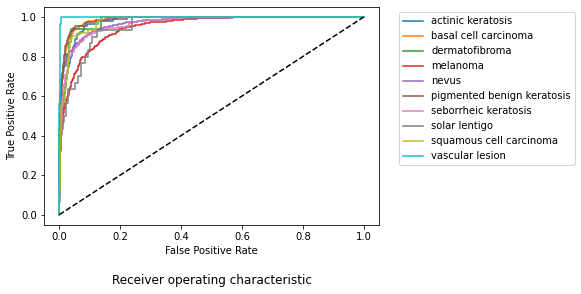

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

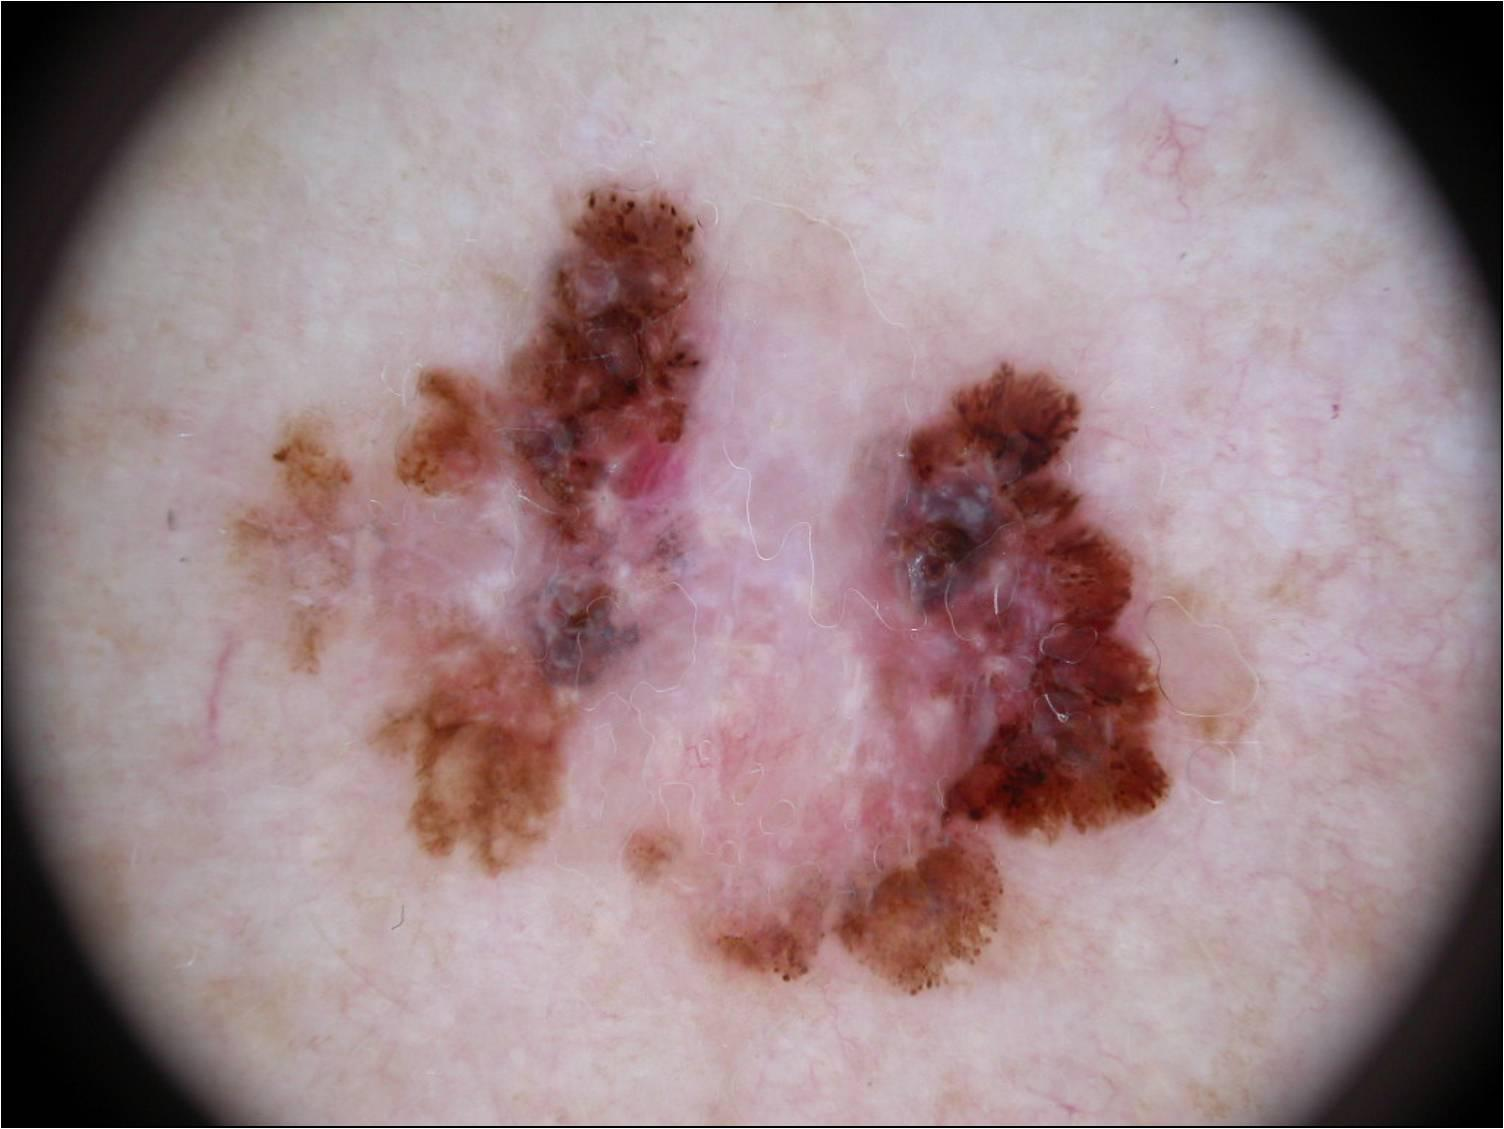

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

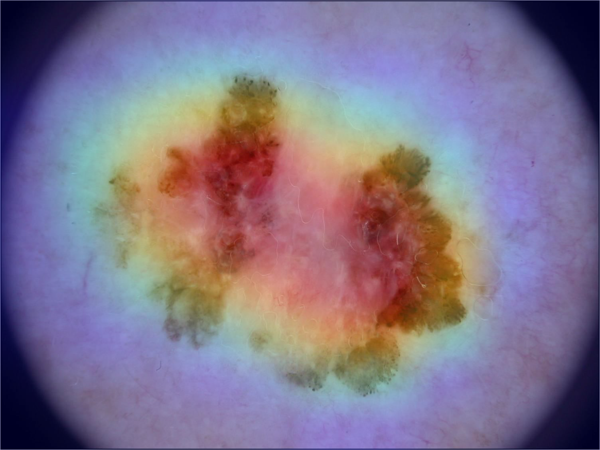

In [23]:
display_gradcam(melanoma_im_path, heatmap)